# Web Analytics Individual Assessment

### Submission by: B212781

# Table of Contents


1. **[Problem Description](#problem)**

2. **[Importing Libraries](#libraries)**

3. **[Pre-Process Data](#pre-process)**
 
4. **[Functions](#functions)**

5. **[Clickstream Analytics](#CA)**

 - 4.1 [Source Performance](#BQ1)
 - 4.2 [Platform Performance](#BQ2)
 - 4.3 [Campaign Performance](#BQ3)
 - 4.4 [Blog Performance](#BQ4)

# Problem Description  <a id='problem'></a>

Imagine you are applying for the position of Business Analyst in Scotland's largest touring company, HaggisBus. As part of the application process, you are asked to create a one-page report to demonstrate your knowledge of the subject and originality of your approach.

HaggisBus has provided you with a dataset (visitor_data_clickstream.csv) that contains web traffic data (click stream) from 160,000 visitors to their website while the company has run three advertisement campaigns (on LinkedIn, Facebook and on Partner websites). Data includes the click stream (list of all pages that each user visited, in order) and user's information: origin and platform.

Origin can have a value "linkedin_advert", "facebook_advert", "partner_advert" to indicate which advert was clicked to open the website; or "linkedin_share", "facebook_share" if someone clicked a post shared by their friend (not a paid advert); or 'direct' for users that typed the URL themselves; or 'search' for those who came to the website via search engine. 

Platform indicates the type of device they used: 'mac', 'windows', 'ios', 'android' or 'unknown' (unknown device means that for various reasons, the platform could not be established, e.g. because of "ad blocker", or because this was a scraping attempt).

Comment on the effectiveness of the three advertisement campaigns by calculating the most appropriate web analytics measures and presenting them in ways you see as most appropriate.

# Importing Libraries  <a id='libraries'></a>

In [1]:
# Importing libraries necessary to conduct explanatory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib
from matplotlib.transforms import Bbox

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Pre-Process Data <a id='pre-process'></a>

In [2]:
# Function to read each line of the file and save it in a dictionary
def turn_line_of_file_into_dict(line_of_file):
    line_of_file = line_of_file.rstrip("\n")
    data_items = line_of_file.split(",") #comma separated data
    return {'source': data_items[0],
            'platform': data_items[1],
            'clickstream': data_items[2:], # slice all data items from third item until end of data as visited webpages count
           }  

all_data = []

# Open file in read mode
with open('visitor_data_clickstream.csv', 'r') as file:
    lines = file.readlines()[0:]  #ignore first line - header row ignored
    for line in lines:
        data_item_dict = turn_line_of_file_into_dict(line)
        all_data.append(data_item_dict)
file.close() 

In [3]:
visitor_df = pd.DataFrame.from_dict(all_data)
visitor_df.tail()

,source,platform,clickstream
160395,search,ios,"[contact_us, home, pricing, purchase_start, pu..."
160396,search,ios,"[home, contact_us]"
160397,facebook_advert,mac,[special_advert_deal]
160398,linkedin_share,android,"[blog_1, contact_us]"
160399,facebook_share,android,"[home, blog_1, home]"


In [4]:
visitor_df.loc[visitor_df['source'].str.contains('share', case=False), 'campaign_type'] = 'share'
visitor_df.loc[visitor_df['source'].str.contains('advert', case=False), 'campaign_type'] = 'advert'
visitor_df.loc[visitor_df['source'].str.contains('search', case=False), 'campaign_type'] = 'direct/search'
visitor_df.loc[visitor_df['source'].str.contains('direct', case=False), 'campaign_type'] = 'direct/search'
visitor_df

,source,platform,clickstream,campaign_type
0,linkedin_share,android,"[blog_1, home, pricing, purchase_start, purcha...",share
1,facebook_share,ios,"[blog_1, pricing, purchase_start, blog_1]",share
2,search,android,"[home, blog_1]",direct/search
3,facebook_share,windows,"[blog_2, home, blog_1]",share
4,facebook_share,ios,"[home, blog_1]",share
...,...,...,...,...
160395,search,ios,"[contact_us, home, pricing, purchase_start, pu...",direct/search
160396,search,ios,"[home, contact_us]",direct/search
160397,facebook_advert,mac,[special_advert_deal],advert
160398,linkedin_share,android,"[blog_1, contact_us]",share


# Functions  <a id='functions'></a>

In [5]:
# Defining a function to drop columns
def drop_column(input_dataframe, column_to_drop):
    new_dataframe = input_dataframe.copy()   
    new_dataframe = new_dataframe.drop(column_to_drop, axis=1)  
    return new_dataframe

In [6]:
# Defining a function to calculate the bounce rate

def calculate_bounce_rate(input_dataframe):
    
    single_page_visitor_count = 0 # Numerator
    total_visitor_count = len(input_dataframe) # Denominator
    
    for visitor in range(len(input_dataframe)):
        if len(input_dataframe.clickstream[visitor]) == 1:
            single_page_visitor_count += 1
   
    bounce_rate = (single_page_visitor_count / total_visitor_count) * 100
    
    return round(bounce_rate,2)

In [7]:
# Defining a function to calculate the conversion rate

def calculate_conversion_rate(input_dataframe):
    
    conversion_count = 0 # Numerator
    total_visitor_count = len(input_dataframe) # Denominator
    
    for visitor in range(len(input_dataframe)):
        for page in range(len(input_dataframe.clickstream[visitor])):
            if input_dataframe.clickstream[visitor][page] == 'purchase_success': # Visitor converted to customer upon successful purchase
                conversion_count+=1
                break
      
    conversion_rate = (conversion_count / total_visitor_count) * 100
    
    return round(conversion_rate,2)

In [8]:
# Defining a function to calculate the average page depth (page per session)

def calculate_average_page_depth(input_dataframe):
    
    page_count = 0 # Numerator
    total_visitor_count = len(input_dataframe) # Denominator
    
    for visitor in range(len(input_dataframe)):
        page_count += len(input_dataframe.clickstream[visitor])
        
    average_page_depth = page_count / total_visitor_count
    
    return round(average_page_depth,2)   

In [9]:
# Defining a function to calculate the dropout rate

def calculate_dropout_rate(input_dataframe):
    
    start_purchase_count = 0
    successful_purchase_count = 0
    
    
    for visitor in range(len(input_dataframe)):
        for page in range(len(input_dataframe.clickstream[visitor])):
            if input_dataframe.clickstream[visitor][page] == 'purchase_start':
                start_purchase_count += 1
            if input_dataframe.clickstream[visitor][page] == 'purchase_success':
                successful_purchase_count += 1
                break
 
    dropout = (1 - (successful_purchase_count/start_purchase_count)) * 100

    return round(dropout,2)   

In [10]:
# Defining a function to calculate the page views

def calculate_page_views(input_dataframe, target_page):
    # Create an empty dictionary to store page views
    page_views = {}
    
    # Iterate over each row in the dataframe
    for index, row in input_dataframe.iterrows():
        
        # Iterate over each page in the clickstream
        for page in row['clickstream']:
            
            # If the page is the target page, increment the page view count
            if page == target_page:
                # If the page is already in the dictionary, increment the page view count
                if page in page_views:
                    page_views[page] += 1

                # If the page is not in the dictionary, add it with a count of 1
                else:
                    page_views[page] = 1
    
    # Create a dataframe from the page views dictionary
    page_views_df = pd.DataFrame(list(page_views.items()), columns=['page', 'page_views'])
    
    return page_views_df

In [11]:
# Defining a function to calculate the exit page count

def calculate_exit_page_count(input_dataframe):
    
    # Create an empty dictionary to store value counts of unique exit pages encountered in dataset
    exit_pages = {}

    # Iterate over each row in the dataframe
    for index, row in input_dataframe.iterrows():
        last_page = row['clickstream'][-1]
        
        if last_page in exit_pages:
            exit_pages[last_page] += 1
            
        else:
            exit_pages[last_page] = 1
    
    # Create a dataframe from the page views dictionary
    exit_pages_df = pd.DataFrame(list(exit_pages.items()), columns=['last_page', 'visitor_session_count'])

    return exit_pages_df

In [12]:
# Defining a function to calculate the exit rate

def calculate_exit_rate(input_dataframe):
    page_views = {}
    exit_pages = {}

    for index, row in input_dataframe.iterrows():
        for page in row['clickstream']:
            if page in page_views:
                page_views[page] += 1
            else:
                page_views[page] = 1

        last_page = row['clickstream'][-1]
        if last_page in exit_pages:
            exit_pages[last_page] += 1
        else:
            exit_pages[last_page] = 1

    exit_rates = {}
    for page, views in page_views.items():
        if page in exit_pages:
            exit_rates[page] = (exit_pages[page] / views) * 100
        else:
            exit_rates[page] = 0

    exit_rates_df = pd.DataFrame(list(exit_rates.items()), columns=['page', 'exit_rate'])
    exit_rates_df = exit_rates_df.sort_values(by='exit_rate', ascending=False).reset_index(drop=True)

    return exit_rates_df

In [13]:
# Defining a function for pie chart plot
def pie_chart_plot(data, keys):
    
    colors = sns.color_palette('pastel')[0:8]
    plt.pie(data, labels = keys, colors = colors, radius=1.5, autopct='%.0f%%', textprops={'fontsize': 16})

In [14]:
# Defining a function for bar chart

def bar_chart_plot(input_data, x_column, y_column, x_label, y_label, ax, title):
  
    sns.barplot(x = x_column, y = y_column, data = input_data, ax = ax, palette ='pastel') 
        
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='x', labelrotation=90, labelsize=14)
    
    # Add values on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 0.05, '{:.1f}'.format(height),
                ha="center", fontsize=12)


# Clickstream Analysis <a id='CA'></a>

## Source Performance <a id='BQ1'></a>

Do the three campaigns perform differently, and what could these differences mean? What measurements did you use to measure each campaign’s performance?

In [15]:
# Creating a separate results dataframe to save analytical results obtained from conducting clickstream analysis

source_results = pd.DataFrame(columns=['source', 'total_visitor_sessions','bounce_rate','average_page_depth','conversion_rate','dropout_rate'])
source_results

,source,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate


In [16]:
# Find the distinct type of platforms present in clickstream data
source_list = list(visitor_df['source'].unique())

source_results['source'] = [source for source in source_list]
source_results

,source,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,linkedin_share,NaN,NaN,NaN,NaN,NaN
1,facebook_share,NaN,NaN,NaN,NaN,NaN
2,search,NaN,NaN,NaN,NaN,NaN
3,direct,NaN,NaN,NaN,NaN,NaN
4,partner_advert,NaN,NaN,NaN,NaN,NaN
5,facebook_advert,NaN,NaN,NaN,NaN,NaN
6,linkedin_advert,NaN,NaN,NaN,NaN,NaN


In [17]:
# Calculating metrics for each source
bounce_rate = []
conversion_rate = []
average_page_depth = []
total_visitor_sessions = []
dropout_rate = []

for source in source_list:
    source_subset_df = visitor_df.loc[visitor_df['source'] == source] # Saving clickstream data of corresponding source separately
    source_subset_df = source_subset_df.reset_index(drop=True) # restting index of each dataframes for accurate visitor estimation
    
    total_visitor_sessions.append(len(source_subset_df))
    bounce_rate.append(calculate_bounce_rate(source_subset_df))
    conversion_rate.append(calculate_conversion_rate(source_subset_df))
    average_page_depth.append(calculate_average_page_depth(source_subset_df))
    dropout_rate.append(calculate_dropout_rate(source_subset_df))

In [18]:
# Copy results in results dataframe

source_results['total_visitor_sessions'] = [session for session in total_visitor_sessions]
source_results

source_results['bounce_rate'] = [bounce for bounce in bounce_rate]
source_results

source_results['conversion_rate'] = [convert for convert in conversion_rate]
source_results

source_results['average_page_depth'] = [page_depth for page_depth in average_page_depth]
source_results

source_results['dropout_rate'] = [dropout for dropout in dropout_rate]
source_results

,source,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,linkedin_share,21200,20.00,3.35,12.01,67.83
1,facebook_share,51300,15.84,3.46,12.98,66.95
2,search,57400,18.36,3.29,15.19,60.15
3,direct,13500,9.53,3.54,31.67,22.93
4,partner_advert,5000,0.00,3.81,10.90,86.11
5,facebook_advert,10000,42.62,1.93,0.93,96.82
6,linkedin_advert,2000,0.00,4.15,25.20,66.95


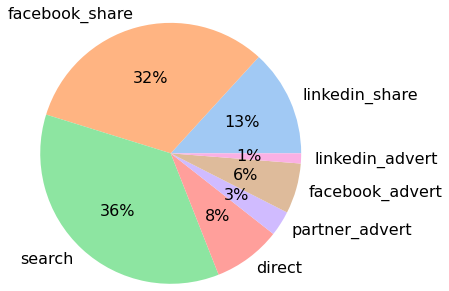

In [19]:
# Plotting distribution of visitors according to their sources
pie_chart_plot(source_results['total_visitor_sessions'], source_results['source'])

# Save the figure
plt.savefig('source_pie_chart.png')

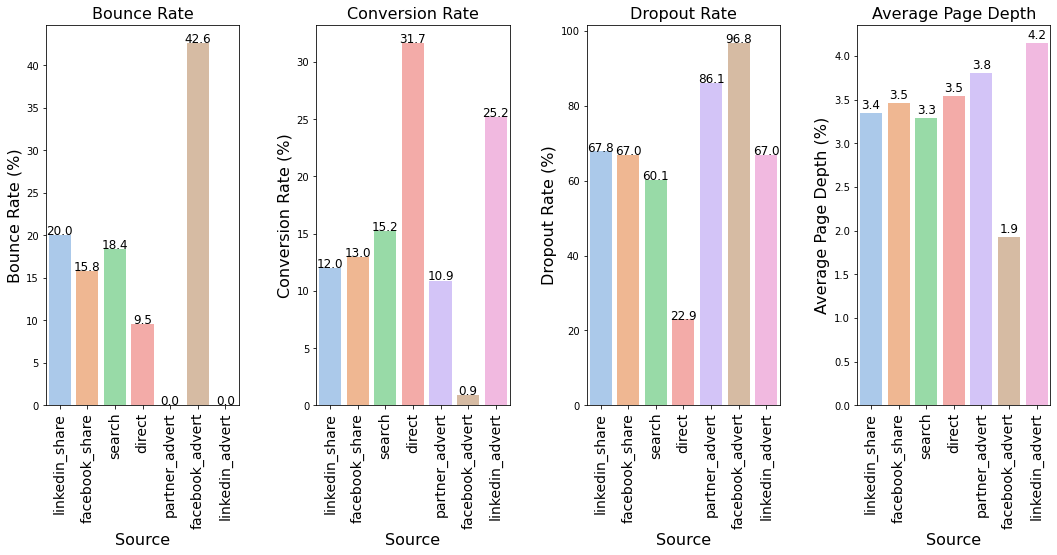

In [20]:
# Create 4 subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,7))

# Call bar_chart() function for each subplot
bar_chart_plot(source_results, 'source', 'bounce_rate', 'Source', 'Bounce Rate (%)', axs[0],"Bounce Rate")
bar_chart_plot(source_results, 'source', 'conversion_rate', 'Source', 'Conversion Rate (%)', axs[1], "Conversion Rate")
bar_chart_plot(source_results, 'source', 'dropout_rate', 'Source', 'Dropout Rate (%)', axs[2], "Dropout Rate")
bar_chart_plot(source_results, 'source', 'average_page_depth', 'Source', 'Average Page Depth (%)', axs[3], "Average Page Depth")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Save the figure
plt.savefig('source_bar_chart.png', bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

## Platform Performance <a id='BQ2'></a>

Do the users from different platforms behave differently? There were concerns that some platforms struggled at a particular stage of the process, can you find these stages?

In [21]:
# Creating a separate results dataframe to save analytical results obtained from conducting clickstream analysis

platform_results = pd.DataFrame(columns=['platform','total_visitor_sessions','bounce_rate','average_page_depth','conversion_rate','dropout_rate'])
platform_results

,platform,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate


In [22]:
# Find the distinct type of platforms present in clickstream data
platform_list = list(visitor_df['platform'].unique())

platform_results['platform'] = [platform for platform in platform_list]
platform_results

,platform,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,android,NaN,NaN,NaN,NaN,NaN
1,ios,NaN,NaN,NaN,NaN,NaN
2,windows,NaN,NaN,NaN,NaN,NaN
3,unknown,NaN,NaN,NaN,NaN,NaN
4,mac,NaN,NaN,NaN,NaN,NaN


In [23]:
# Calculating metrics for each platform
bounce_rate = []
conversion_rate = []
average_page_depth = []
total_visitor_sessions = []
dropout_rate = []

for platform in platform_list:
    platform_subset_df = visitor_df.loc[visitor_df['platform'] == platform] # Saving clickstream data of corresponding source separately
    platform_subset_df = platform_subset_df.reset_index(drop=True) # restting index of each dataframes for accurate visitor estimation
    
    total_visitor_sessions.append(len(platform_subset_df))
    bounce_rate.append(calculate_bounce_rate(platform_subset_df))
    conversion_rate.append(calculate_conversion_rate(platform_subset_df))
    average_page_depth.append(calculate_average_page_depth(platform_subset_df))
    dropout_rate.append(calculate_dropout_rate(platform_subset_df))

In [24]:
# Copy results in results dataframe

platform_results['total_visitor_sessions'] = [session for session in total_visitor_sessions]
platform_results

platform_results['bounce_rate'] = [bounce for bounce in bounce_rate]
platform_results

platform_results['conversion_rate'] = [convert for convert in conversion_rate]
platform_results

platform_results['average_page_depth'] = [page_depth for page_depth in average_page_depth]
platform_results

platform_results['dropout_rate'] = [dropout for dropout in dropout_rate]
platform_results

,platform,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,android,44500,17.98,3.34,14.93,62.21
1,ios,44500,17.98,3.27,12.69,67.53
2,windows,28000,16.46,3.37,16.40,59.88
3,unknown,15400,21.69,3.16,12.83,67.17
4,mac,28000,16.06,3.37,16.00,60.76


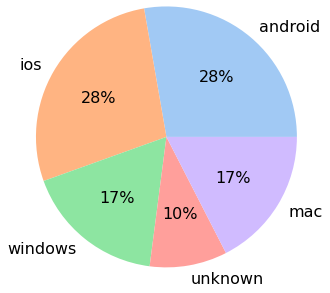

In [25]:
# Plotting distribution of visitors according to their sources
pie_chart_plot(platform_results['total_visitor_sessions'], platform_results['platform'])

# Save the figure
plt.savefig('platform_pie_chart.png')

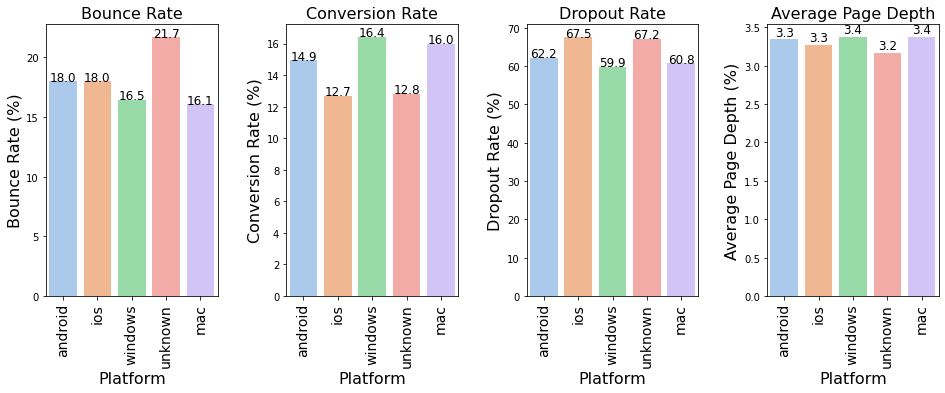

In [26]:
# Create 4 subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

# Call bar_chart() function for each subplot
bar_chart_plot(platform_results, 'platform', 'bounce_rate', 'Platform', 'Bounce Rate (%)', axs[0],"Bounce Rate")
bar_chart_plot(platform_results, 'platform', 'conversion_rate', 'Platform', 'Conversion Rate (%)', axs[1], "Conversion Rate")
bar_chart_plot(platform_results, 'platform', 'dropout_rate', 'Platform', 'Dropout Rate (%)', axs[2], "Dropout Rate")
bar_chart_plot(platform_results, 'platform', 'average_page_depth', 'Platform', 'Average Page Depth (%)', axs[3], "Average Page Depth")
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Save the figure
plt.savefig('platform_bar_chart.png', bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

In [27]:
for platform in platform_list:
    platform_subset_df = visitor_df.loc[visitor_df['platform'] == platform] # Saving clickstream data of corresponding source separately
    platform_subset_df = platform_subset_df.reset_index(drop=True) # restting index of each dataframes for accurate visitor estimation
     
    print(f"\nThe exit rates corresponding to each page for the {platform} platform is")
    print(calculate_exit_rate(platform_subset_df))


The exit rates corresponding to each page for the android platform is
                     page  exit_rate
0        purchase_success  81.158336
1              contact_us  74.471497
2                  blog_1  37.498653
3     special_advert_deal  23.705882
4  purchase_enter_address  21.647446
5                 pricing  20.523212
6          purchase_start  20.502353
7                    home  19.555825
8                  blog_2  14.537284

The exit rates corresponding to each page for the ios platform is
                     page  exit_rate
0        purchase_success  83.203952
1              contact_us  74.173632
2                  blog_1  37.700257
3  purchase_enter_address  35.758870
4     special_advert_deal  26.000000
5                 pricing  20.008075
6          purchase_start  19.959851
7                    home  19.123761
8                  blog_2  14.699742

The exit rates corresponding to each page for the windows platform is
                     page  exit_rate
0        purch

In [28]:
# Create an empty list to store the exit rate dataframes
platform_exit_rate_df = []

for platform in platform_list:
    platform_subset_df = visitor_df.loc[visitor_df['platform'] == platform] # Saving clickstream data of corresponding platform separately
    platform_subset_df = platform_subset_df.reset_index(drop=True) # restting index of each dataframes for accurate visitor estimation
     
    # Calculate exit rates for the current platform type and append the result to the exit_rate_dfs list
    exit_rate_df = calculate_exit_rate(platform_subset_df)
    exit_rate_df['platform'] = platform # Add a column to identify the platform type in the table
    platform_exit_rate_df.append(exit_rate_df)

# Concatenate the exit rate dataframes and create a table
platform_exit_rate_table = pd.concat(platform_exit_rate_df).reset_index(drop=True)
platform_exit_rate_table

,page,exit_rate,platform
0,purchase_success,81.158336,android
1,contact_us,74.471497,android
2,blog_1,37.498653,android
3,special_advert_deal,23.705882,android
4,purchase_enter_address,21.647446,android
5,pricing,20.523212,android
6,purchase_start,20.502353,android
7,home,19.555825,android
8,blog_2,14.537284,android
9,purchase_success,83.203952,ios


## Campaign Performance <a id='BQ3'></a>

How does performance of users coming via adverts compare with those that came via social media shares? How about those who came to the site directly, or via search engine?

In [29]:
# Creating a separate campaign dataframe to save analytical results obtained from conducting clickstream analysis

campaign_results = pd.DataFrame(columns=['campaign_type', 'total_visitor_sessions','bounce_rate','average_page_depth','conversion_rate','dropout_rate'])
campaign_results

,campaign_type,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate


In [30]:
# Find the distinct type of platforms present in clickstream data
campaign_list = list(visitor_df['campaign_type'].unique())

campaign_results['campaign_type'] = [campaign for campaign in campaign_list]
campaign_results

,campaign_type,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,share,NaN,NaN,NaN,NaN,NaN
1,direct/search,NaN,NaN,NaN,NaN,NaN
2,advert,NaN,NaN,NaN,NaN,NaN


In [31]:
# Calculating metrics for each performance type
bounce_rate = []
conversion_rate = []
average_page_depth = []
total_visitor_sessions = []
dropout_rate = []

for campaign_type in campaign_list:
    source_subset_df = visitor_df.loc[visitor_df['campaign_type'] == campaign_type] # Saving clickstream data of corresponding source separately
    source_subset_df = source_subset_df.reset_index(drop=True) # restting index of each dataframes for accurate visitor estimation
    
    total_visitor_sessions.append(len(source_subset_df))
    bounce_rate.append(calculate_bounce_rate(source_subset_df))
    conversion_rate.append(calculate_conversion_rate(source_subset_df))
    average_page_depth.append(calculate_average_page_depth(source_subset_df))
    dropout_rate.append(calculate_dropout_rate(source_subset_df))

In [32]:
# Copy results in results dataframe

campaign_results['total_visitor_sessions'] = [session for session in total_visitor_sessions]
campaign_results

campaign_results['bounce_rate'] = [bounce for bounce in bounce_rate]
campaign_results

campaign_results['conversion_rate'] = [convert for convert in conversion_rate]
campaign_results

campaign_results['average_page_depth'] = [page_depth for page_depth in average_page_depth]
campaign_results

campaign_results['dropout_rate'] = [dropout for dropout in dropout_rate]
campaign_results

,campaign_type,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,share,72500,17.05,3.42,12.69,67.19
1,direct/search,70900,16.68,3.34,18.33,52.62
2,advert,17000,25.07,2.74,6.72,86.37


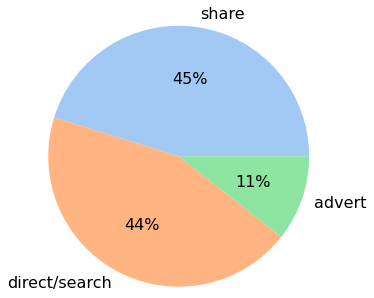

In [33]:
# Plotting distribution of visitors according to their sources
pie_chart_plot(campaign_results['total_visitor_sessions'], campaign_results['campaign_type'])

# Save the figure
plt.savefig('campaign_pie_chart.png')

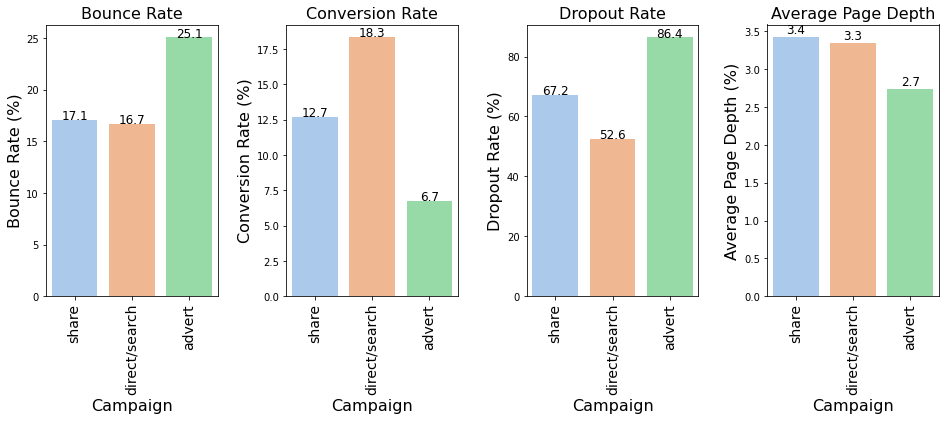

In [34]:
# Create 4 subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

# Call bar_chart() function for each subplot
bar_chart_plot(campaign_results, 'campaign_type', 'bounce_rate', 'Campaign', 'Bounce Rate (%)', axs[0],"Bounce Rate")
bar_chart_plot(campaign_results, 'campaign_type', 'conversion_rate', 'Campaign', 'Conversion Rate (%)', axs[1], "Conversion Rate")
bar_chart_plot(campaign_results, 'campaign_type', 'dropout_rate', 'Campaign', 'Dropout Rate (%)', axs[2], "Dropout Rate")
bar_chart_plot(campaign_results, 'campaign_type', 'average_page_depth', 'Campaign', 'Average Page Depth (%)', axs[3], "Average Page Depth")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Save the figure
plt.savefig('campaign_bar_chart.png', bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

## Blog Performance <a id='BQ4'></a>

Which blog converts better? (so that you know you should write more of similar ones in the future)

In [35]:
# Creating a separate blogs dataframe to save analytical results obtained from conducting clickstream analysis

blog_results = pd.DataFrame(columns=['blog','total_visitor_sessions','bounce_rate','average_page_depth','conversion_rate','dropout_rate'])
blog_results

,blog,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate


In [36]:
# Find the distinct type of platforms present in clickstream data
blog_list = ['blog_1', 'blog_2']

blog_results['blog'] = [blog for blog in blog_list]
blog_results

,blog,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,blog_1,NaN,NaN,NaN,NaN,NaN
1,blog_2,NaN,NaN,NaN,NaN,NaN


In [37]:
blog_df = visitor_df.copy()

drop_list = ['source', 'platform', 'campaign_type']

for column in drop_list:
    blog_df = drop_column(blog_df, column)

blog_df

,clickstream
0,"[blog_1, home, pricing, purchase_start, purcha..."
1,"[blog_1, pricing, purchase_start, blog_1]"
2,"[home, blog_1]"
3,"[blog_2, home, blog_1]"
4,"[home, blog_1]"
...,...
160395,"[contact_us, home, pricing, purchase_start, pu..."
160396,"[home, contact_us]"
160397,[special_advert_deal]
160398,"[blog_1, contact_us]"


⚠️ Note: The below cell takes a long time to execute due to the large number of visitor rows and individual pages the loops has to traverse

In [38]:
# Creating a subset of blog 1 and blog 2 dataframes
blog1_df = pd.DataFrame(columns=blog_df.columns)
blog2_df = pd.DataFrame(columns=blog_df.columns)

for visitor in blog_df.index:
    for page in range(len(blog_df.clickstream[visitor])):
        if blog_df.clickstream[visitor][page] == 'blog_1':
            blog1_df = pd.concat([blog1_df, blog_df.loc[[visitor]]])
        if blog_df.clickstream[visitor][page] == 'blog_2':
            blog2_df = pd.concat([blog2_df, blog_df.loc[[visitor]]])

In [39]:
# Resetting index of blog subset df

blog1_df = blog1_df.reset_index(drop=True)
blog1_df

,clickstream
0,"[blog_1, home, pricing, purchase_start, purcha..."
1,"[blog_1, pricing, purchase_start, blog_1]"
2,"[blog_1, pricing, purchase_start, blog_1]"
3,"[home, blog_1]"
4,"[blog_2, home, blog_1]"
...,...
61528,"[home, blog_1]"
61529,"[home, blog_1, home]"
61530,"[home, blog_1]"
61531,"[blog_1, contact_us]"


In [40]:
# Resetting index of blog subset df

blog2_df = blog2_df.reset_index(drop=True)
blog2_df

,clickstream
0,"[blog_2, home, blog_1]"
1,"[blog_2, pricing, purchase_start]"
2,"[blog_2, pricing, purchase_start, purchase_ent..."
3,"[blog_2, pricing, blog_1]"
4,"[home, blog_2]"
...,...
26975,"[blog_2, pricing, purchase_start, purchase_ent..."
26976,"[home, pricing, contact_us, blog_2, pricing, p..."
26977,"[blog_2, pricing, purchase_start, purchase_ent..."
26978,"[home, blog_2, home]"


In [41]:
# Calculating metrics for each performance type
bounce_rate = []
conversion_rate = []
average_page_depth = []
total_visitor_sessions = []
dropout_rate = []

# Calculate metrics for blog_1
total_visitor_sessions.append(len(blog1_df))
bounce_rate.append(calculate_bounce_rate(blog1_df))
conversion_rate.append(calculate_conversion_rate(blog1_df))
average_page_depth.append(calculate_average_page_depth(blog1_df))
dropout_rate.append(calculate_dropout_rate(blog1_df))

# Calculate metrics for blog_2
total_visitor_sessions.append(len(blog2_df))
bounce_rate.append(calculate_bounce_rate(blog2_df))
conversion_rate.append(calculate_conversion_rate(blog2_df))
average_page_depth.append(calculate_average_page_depth(blog2_df))
dropout_rate.append(calculate_dropout_rate(blog2_df))

In [42]:
# Copy results in results dataframe

blog_results['total_visitor_sessions'] = [session for session in total_visitor_sessions]
blog_results

blog_results['bounce_rate'] = [bounce for bounce in bounce_rate]
blog_results

blog_results['conversion_rate'] = [convert for convert in conversion_rate]
blog_results

blog_results['average_page_depth'] = [page_depth for page_depth in average_page_depth]
blog_results

blog_results['dropout_rate'] = [dropout for dropout in dropout_rate]
blog_results

,blog,total_visitor_sessions,bounce_rate,average_page_depth,conversion_rate,dropout_rate
0,blog_1,61533,13.17,3.75,10.05,67.0
1,blog_2,26980,2.69,4.55,18.01,60.1


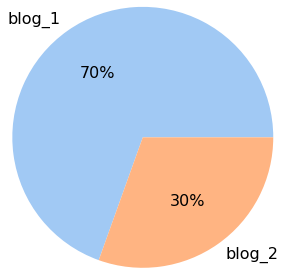

In [43]:
# Plotting distribution of visitors according to their sources
pie_chart_plot(blog_results['total_visitor_sessions'], blog_results['blog'])

# Save the figure
plt.savefig('blog_pie_chart.png')

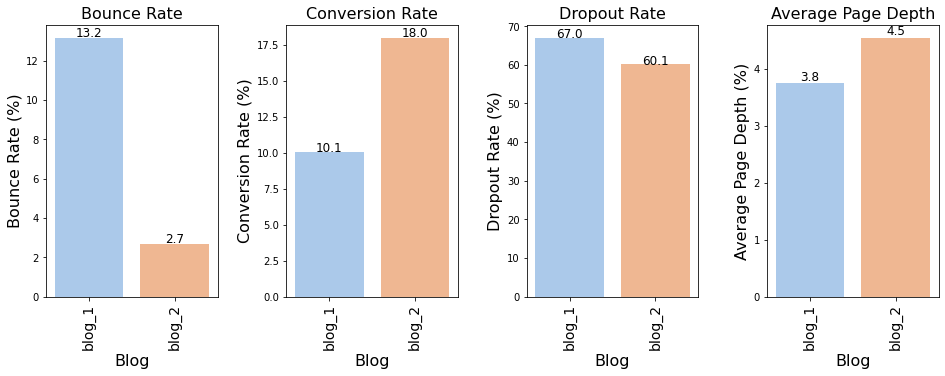

In [44]:
# Create 4 subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

# Call bar_chart() function for each subplot
bar_chart_plot(blog_results, 'blog', 'bounce_rate', 'Blog', 'Bounce Rate (%)', axs[0],"Bounce Rate")
bar_chart_plot(blog_results, 'blog', 'conversion_rate', 'Blog', 'Conversion Rate (%)', axs[1], "Conversion Rate")
bar_chart_plot(blog_results, 'blog', 'dropout_rate', 'Blog', 'Dropout Rate (%)', axs[2], "Dropout Rate")
bar_chart_plot(blog_results, 'blog', 'average_page_depth', 'Blog', 'Average Page Depth (%)', axs[3], "Average Page Depth")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Save the figure
plt.savefig('blog_bar_chart.png', bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))